## Translated BETO Model

## STEP 1: Mount Drive & Install Dependencies

In [ ]:
!pip install -U transformers datasets scikit-learn matplotlib seaborn

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Load dataset as a DataFrame
df = pd.read_csv('/content/drive/MyDrive/traducido_dataset_unificado_v_30jun.csv')

# Preview the dataset
df

/tmp/ipython-input-11-3159178268.py:4: DtypeWarning: Columns (9,10,11,12,13,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/traducido_dataset_unificado_v_30jun.csv')


,source_dataset,target_column,subcategory_combined,text,text_english,text_spanish,id,subcategory_general,subcategory_specific,rewire_id,...,TR,AG,label,test_case,source,language,task1,task2,detected_language,multiclass_final
0,edos_labelled_aggregated,0,NaN,"In Nigeria, if you rape a woman, the men rape ...","In Nigeria, if you rape a woman, the men rape ...","En Nigeria, si violas a una mujer, ¡los hombre...",NaN,NaN,NaN,sexism2022_english-9609,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN
1,edos_labelled_aggregated,0,NaN,"Then, she's a keeper. 😉","Then, she's a keeper. 😉","Entonces, ella es una guardiana. 😉",NaN,NaN,NaN,sexism2022_english-16993,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN
2,edos_labelled_aggregated,0,NaN,This is like the Metallica video where the poo...,This is like the Metallica video where the poo...,Esto es como el vídeo de Metallica donde el po...,NaN,NaN,NaN,sexism2022_english-13149,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN
3,edos_labelled_aggregated,0,NaN,woman?,woman?,¿mujer?,NaN,NaN,NaN,sexism2022_english-13021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,so,NaN
4,edos_labelled_aggregated,0,NaN,I bet she wished she had a gun,I bet she wished she had a gun,Apuesto a que deseaba tener un arma.,NaN,NaN,NaN,sexism2022_english-966,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44347,EXIST2021_training,0,NaN,"Estamos igual sin pareja, pero puedes besar a ...","We're the same without a partner, but you can ...","Estamos igual sin pareja, pero puedes besar a ...",6973.0,NaN,NaN,NaN,...,NaN,NaN,NaN,EXIST2021,twitter,es,non-sexist,non-sexist,es,NaN
44348,EXIST2021_training,0,NaN,2020 hijo de re mil putas,2020 son of a bitch,2020 hijo de re mil putas,6974.0,NaN,NaN,NaN,...,NaN,NaN,NaN,EXIST2021,twitter,es,non-sexist,non-sexist,es,NaN
44349,EXIST2021_training,0,NaN,SEGURAMENTE ESTA CHICA NO COBRA EL DINERO QUE ...,SURELY THIS GIRL DOESN'T GET PAID THE MONEY SH...,SEGURAMENTE ESTA CHICA NO COBRA EL DINERO QUE ...,6975.0,NaN,NaN,NaN,...,NaN,NaN,NaN,EXIST2021,twitter,es,non-sexist,non-sexist,pt,NaN
44350,EXIST2021_training,1,NaN,@safetyaitana mi madre dice q va fea y i agree,@safetyaitana my mother says she looks ugly an...,@safetyaitana mi madre dice q va fea y estoy d...,6976.0,NaN,NaN,NaN,...,NaN,NaN,NaN,EXIST2021,twitter,es,sexist,objectification,ca,NaN


## STEP 2: Load and Subsample 50% of the Dataset

In [ ]:
df = df[['text_spanish', 'target_column']].dropna()
df['target_column'] = df['target_column'].astype(int)
df = df.rename(columns={'text_spanish': 'text', 'target_column': 'label'})

# Subsample 50% of the dataset
df = df.sample(frac=0.5, random_state=42).reset_index(drop=True)

## STEP 3: Split & Tokenize

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)

train_dataset = Dataset.from_dict({**train_encodings, "label": list(train_labels)})
eval_dataset = Dataset.from_dict({**val_encodings, "label": list(val_labels)})

## STEP 4: Define Model + Metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted", zero_division=0),
        "recall": recall_score(labels, preds, average="weighted", zero_division=0),
        "f1": f1_score(labels, preds, average="weighted")
    }

def model_init():
    from transformers import AutoModelForSequenceClassification
    return AutoModelForSequenceClassification.from_pretrained(
        "dccuchile/bert-base-spanish-wwm-cased", num_labels=2
    )

## STEP 5: Set Best Hyperparameters & Train

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results-final",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs-final",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
)

trainer = Trainer(
    args=training_args,
    model_init=model_init,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipython-input-15-3031624288.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.421600,0.418944,0.813571,0.807671,0.813571,0.800819
2,0.304200,0.431909,0.817403,0.823911,0.817403,0.819911
3,0.168900,0.725124,0.816050,0.813129,0.816050,0.814320
4,0.070200,1.014277,0.815600,0.809659,0.815600,0.810874


TrainOutput(global_step=4436, training_loss=0.24834748105598636, metrics={'train_runtime': 5470.0039, 'train_samples_per_second': 12.973, 'train_steps_per_second': 0.811, 'total_flos': 1.4768546870664e+16, 'train_loss': 0.24834748105598636, 'epoch': 4.0})

In [ ]:
output_dir = "/content/drive/MyDrive/BETO/final_beto_model"

trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('/content/drive/MyDrive/BETO/final_beto_model/tokenizer_config.json',
 '/content/drive/MyDrive/BETO/final_beto_model/special_tokens_map.json',
 '/content/drive/MyDrive/BETO/final_beto_model/vocab.txt',
 '/content/drive/MyDrive/BETO/final_beto_model/added_tokens.json',
 '/content/drive/MyDrive/BETO/final_beto_model/tokenizer.json')

In [ ]:
import numpy as np

# Save predictions and labels
np.save("/content/drive/MyDrive/BETO/preds.npy", preds)
np.save("/content/drive/MyDrive/BETO/labels.npy", labels)

## STEP 6: Evaluate + Save Metrics to Google Drive

📊 Final Evaluation Metrics:
Accuracy: 0.8174030658250676
Precision: 0.8239109909295246
Recall: 0.8174030658250676
F1 Score: 0.8199110050049871

📑 Classification Report (per class):
              precision    recall  f1-score   support

  non-sexist       0.89      0.85      0.87      3160
      sexist       0.67      0.73      0.70      1276

    accuracy                           0.82      4436
   macro avg       0.78      0.79      0.78      4436
weighted avg       0.82      0.82      0.82      4436



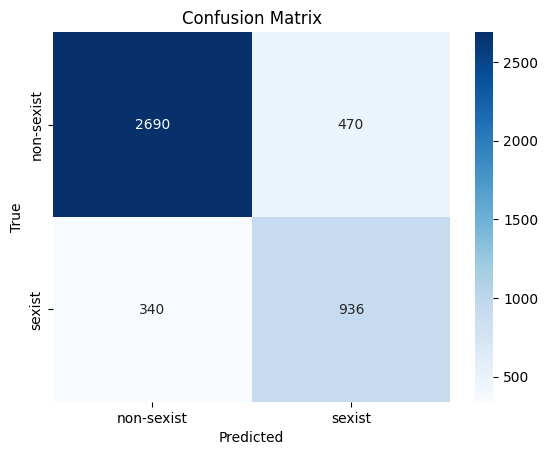

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Ensure output folder exists
os.makedirs("/content/drive/MyDrive/BETO", exist_ok=True)

# Predict on validation set
predictions = trainer.predict(eval_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Print metrics
print("📊 Final Evaluation Metrics:")
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds, average="weighted", zero_division=0)
recall = recall_score(labels, preds, average="weighted", zero_division=0)
f1 = f1_score(labels, preds, average="weighted")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Print classification report
report = classification_report(labels, preds, target_names=["non-sexist", "sexist"])
print("\n📑 Classification Report (per class):")
print(report)

# Confusion matrix
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["non-sexist", "sexist"], yticklabels=["non-sexist", "sexist"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Save results to text file in Google Drive
results_path = "/content/drive/MyDrive/BETO/beto_final_evaluation_metrics.txt"

with open(results_path, "w") as f:
    f.write("📊 Final Evaluation Metrics\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write(f"Precision (weighted): {precision:.4f}\n")
    f.write(f"Recall (weighted): {recall:.4f}\n")
    f.write(f"F1 Score (weighted): {f1:.4f}\n\n")
    f.write("📑 Classification Report (Per Class)\n")
    f.write(report)

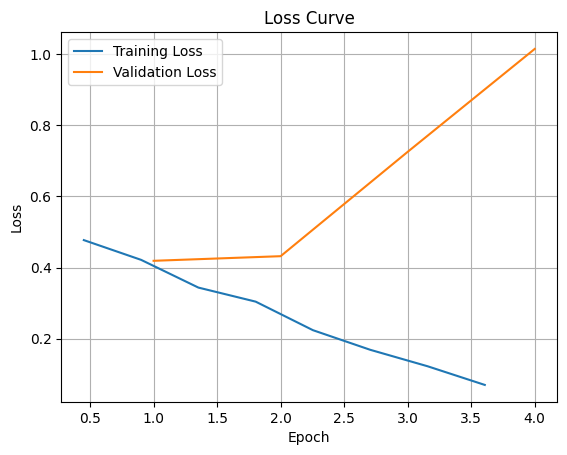

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Get training logs
logs = trainer.state.log_history
df = pd.DataFrame(logs)

# Filter logs that contain loss values
train_loss = df[df["loss"].notnull()]
eval_loss = df[df["eval_loss"].notnull()]

# Plot
plt.plot(train_loss["epoch"], train_loss["loss"], label="Training Loss")
plt.plot(eval_loss["epoch"], eval_loss["eval_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

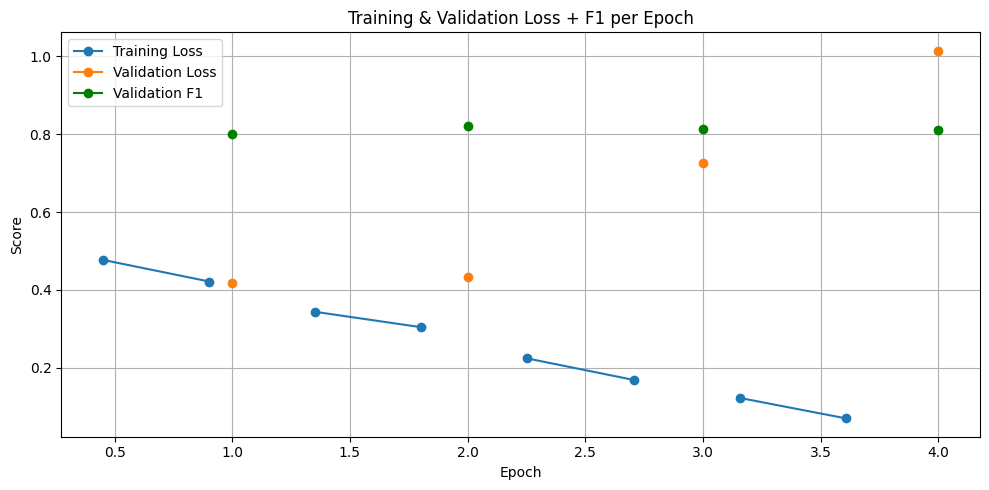

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert training logs to DataFrame
df = pd.DataFrame(trainer.state.log_history)

# Filter for epoch-level rows
df = df[df["epoch"].notnull()]

# Plot loss and F1
plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["loss"], label="Training Loss", marker='o')
if "eval_loss" in df.columns:
    plt.plot(df["epoch"], df["eval_loss"], label="Validation Loss", marker='o')
if "eval_f1" in df.columns:
    plt.plot(df["epoch"], df["eval_f1"], label="Validation F1", marker='o', color='green')

plt.title("Training & Validation Loss + F1 per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

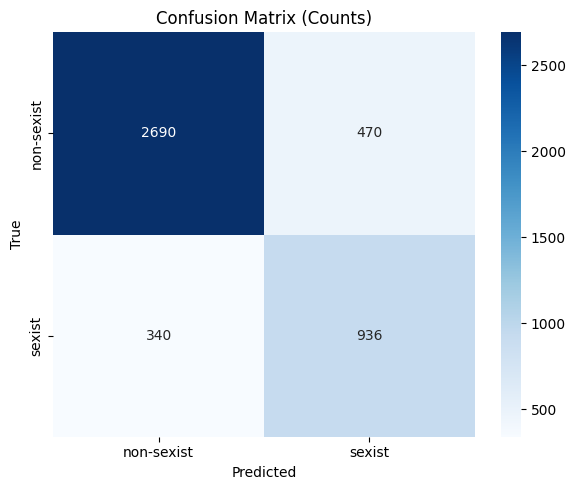

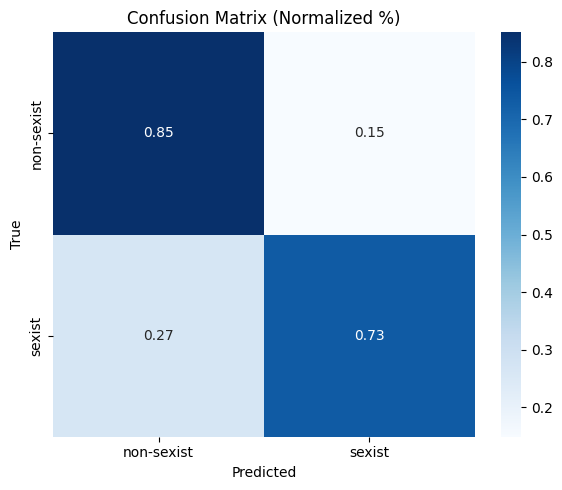

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, preds)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["non-sexist", "sexist"], yticklabels=["non-sexist", "sexist"])
plt.title("Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Normalized (optional second chart)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=["non-sexist", "sexist"], yticklabels=["non-sexist", "sexist"])
plt.title("Confusion Matrix (Normalized %)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

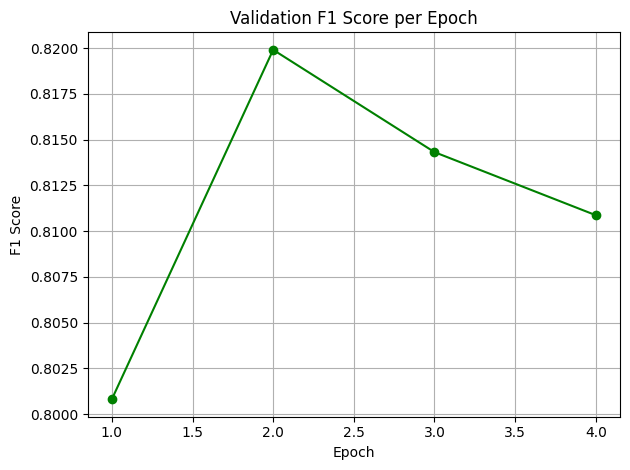

In [ ]:
df_f1 = df[df["eval_f1"].notnull()]

plt.plot(df_f1["epoch"], df_f1["eval_f1"], marker='o', color='green')
plt.title("Validation F1 Score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.grid(True)
plt.tight_layout()
plt.show()

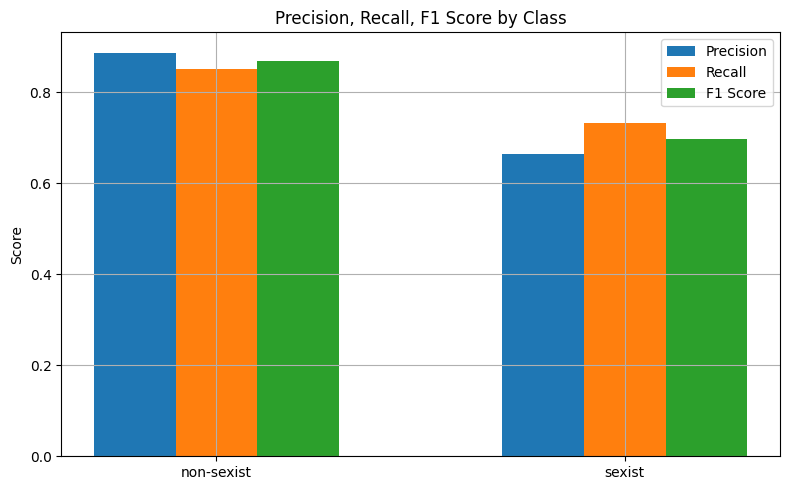

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision_cls, recall_cls, f1_cls, _ = precision_recall_fscore_support(labels, preds)

classes = ["non-sexist", "sexist"]
x = range(len(classes))

plt.figure(figsize=(8, 5))
plt.bar(x, precision_cls, width=0.2, label='Precision', align='center')
plt.bar([i + 0.2 for i in x], recall_cls, width=0.2, label='Recall', align='center')
plt.bar([i + 0.4 for i in x], f1_cls, width=0.2, label='F1 Score', align='center')

plt.xticks([i + 0.2 for i in x], classes)
plt.ylabel("Score")
plt.title("Precision, Recall, F1 Score by Class")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

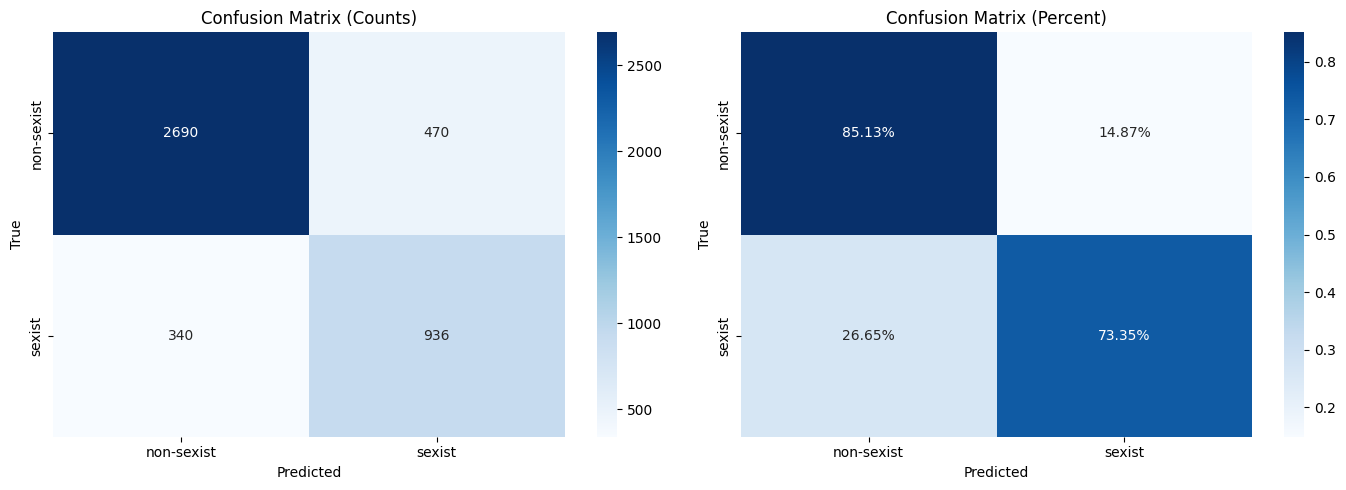

In [ ]:
import numpy as np

cm = confusion_matrix(labels, preds)
cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["non-sexist", "sexist"], yticklabels=["non-sexist", "sexist"], ax=ax[0])
ax[0].set_title("Confusion Matrix (Counts)")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")

# Percentages
sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap="Blues", xticklabels=["non-sexist", "sexist"], yticklabels=["non-sexist", "sexist"], ax=ax[1])
ax[1].set_title("Confusion Matrix (Percent)")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("True")

plt.tight_layout()
plt.show()

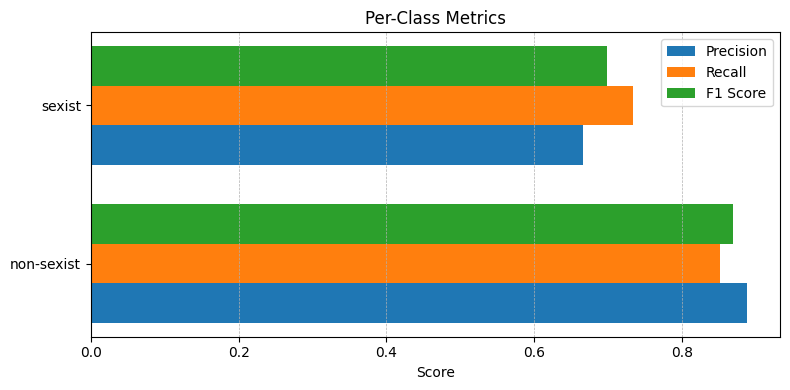

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Get per-class scores
precision_cls, recall_cls, f1_cls, _ = precision_recall_fscore_support(labels, preds)
classes = ["non-sexist", "sexist"]

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
bar_width = 0.25
x = np.arange(len(classes))

ax.barh(x, precision_cls, height=bar_width, label='Precision')
ax.barh(x + bar_width, recall_cls, height=bar_width, label='Recall')
ax.barh(x + 2*bar_width, f1_cls, height=bar_width, label='F1 Score')

ax.set_yticks(x + bar_width)
ax.set_yticklabels(classes)
ax.set_xlabel("Score")
ax.set_title("Per-Class Metrics")
ax.legend()
ax.grid(True, axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

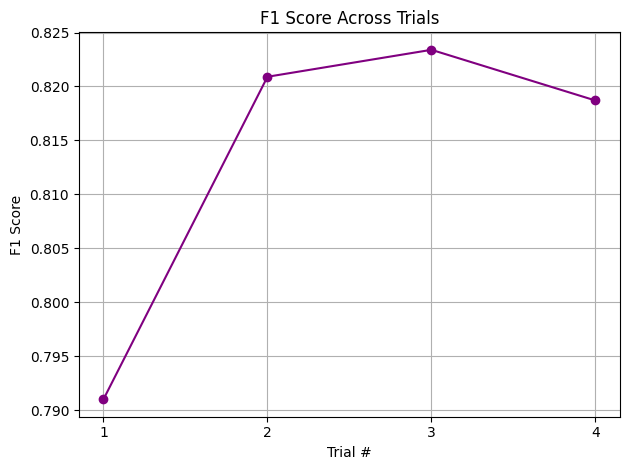

In [ ]:
# Example if you have F1 scores across trials:
f1_scores = [0.791, 0.8209, 0.8234, 0.8187]  # replace with your values

plt.plot(range(1, len(f1_scores)+1), f1_scores, marker='o', linestyle='-', color='purple')
plt.title("F1 Score Across Trials")
plt.xlabel("Trial #")
plt.ylabel("F1 Score")
plt.xticks(range(1, len(f1_scores)+1))
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-26-1725594819.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette="pastel")


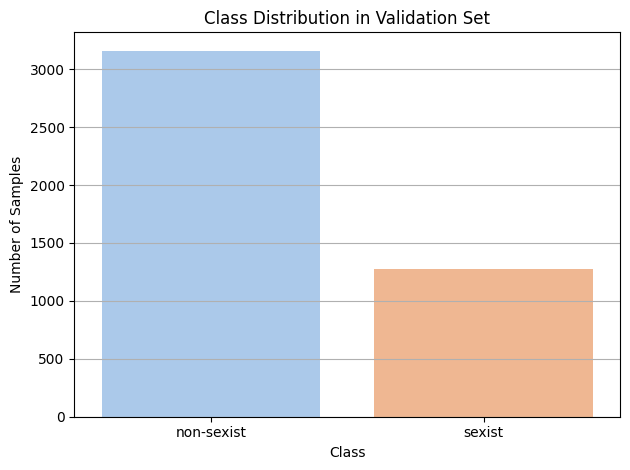

In [ ]:
import seaborn as sns
sns.countplot(x=labels, palette="pastel")
plt.xticks([0, 1], ["non-sexist", "sexist"])
plt.title("Class Distribution in Validation Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

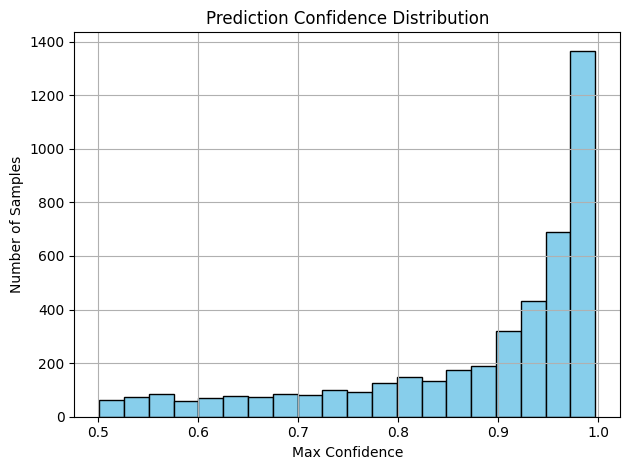

In [ ]:
import torch
probs = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1)
confidences = probs.max(dim=1).values.numpy()

plt.hist(confidences, bins=20, color="skyblue", edgecolor="black")
plt.title("Prediction Confidence Distribution")
plt.xlabel("Max Confidence")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.tight_layout()
plt.show()

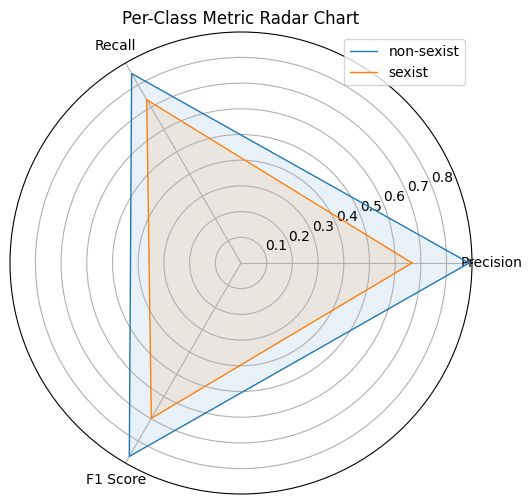

In [ ]:
from math import pi

metrics = precision_cls, recall_cls, f1_cls
labels_plot = ["non-sexist", "sexist"]
categories = ['Precision', 'Recall', 'F1 Score']

import pandas as pd
df_radar = pd.DataFrame(metrics, index=categories, columns=labels_plot).T.reset_index()

# Radar chart
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

for i, row in df_radar.iterrows():
    values = row.drop("index").values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=row["index"])
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.title("Per-Class Metric Radar Chart")
plt.legend(loc='upper right')
plt.show()